In [1]:
import pandas as pd
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score ,classification_report ,roc_curve, auc ,precision_recall_curve


import os
import cv2
from tqdm import tqdm
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.regularizers import l2
from tensorflow.keras.optimizers import Adam

In [2]:
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

Num GPUs Available:  1


In [3]:
train_path ='/kaggle/input/new-plant-diseases-dataset/new plant diseases dataset(augmented)/New Plant Diseases Dataset(Augmented)/train'
test_path = '/kaggle/input/new-plant-diseases-dataset/new plant diseases dataset(augmented)/New Plant Diseases Dataset(Augmented)/valid'

In [4]:
img_size=100

train_generator=tf.keras.preprocessing.image.ImageDataGenerator(
    rotation_range=50,
    zoom_range=0.2,
    rescale=1/255.0,
    preprocessing_function=None,
    validation_split=0.1,
).flow_from_directory(train_path,
                      batch_size=64,
                      target_size=(img_size, img_size),
                      subset="training",
                      color_mode='rgb', 
                      class_mode='categorical', 
                      shuffle=True)

Found 63282 images belonging to 38 classes.


In [5]:
labels=list(train_generator.class_indices.keys())
labels

['Apple___Apple_scab',
 'Apple___Black_rot',
 'Apple___Cedar_apple_rust',
 'Apple___healthy',
 'Blueberry___healthy',
 'Cherry_(including_sour)___Powdery_mildew',
 'Cherry_(including_sour)___healthy',
 'Corn_(maize)___Cercospora_leaf_spot Gray_leaf_spot',
 'Corn_(maize)___Common_rust_',
 'Corn_(maize)___Northern_Leaf_Blight',
 'Corn_(maize)___healthy',
 'Grape___Black_rot',
 'Grape___Esca_(Black_Measles)',
 'Grape___Leaf_blight_(Isariopsis_Leaf_Spot)',
 'Grape___healthy',
 'Orange___Haunglongbing_(Citrus_greening)',
 'Peach___Bacterial_spot',
 'Peach___healthy',
 'Pepper,_bell___Bacterial_spot',
 'Pepper,_bell___healthy',
 'Potato___Early_blight',
 'Potato___Late_blight',
 'Potato___healthy',
 'Raspberry___healthy',
 'Soybean___healthy',
 'Squash___Powdery_mildew',
 'Strawberry___Leaf_scorch',
 'Strawberry___healthy',
 'Tomato___Bacterial_spot',
 'Tomato___Early_blight',
 'Tomato___Late_blight',
 'Tomato___Leaf_Mold',
 'Tomato___Septoria_leaf_spot',
 'Tomato___Spider_mites Two-spotted_

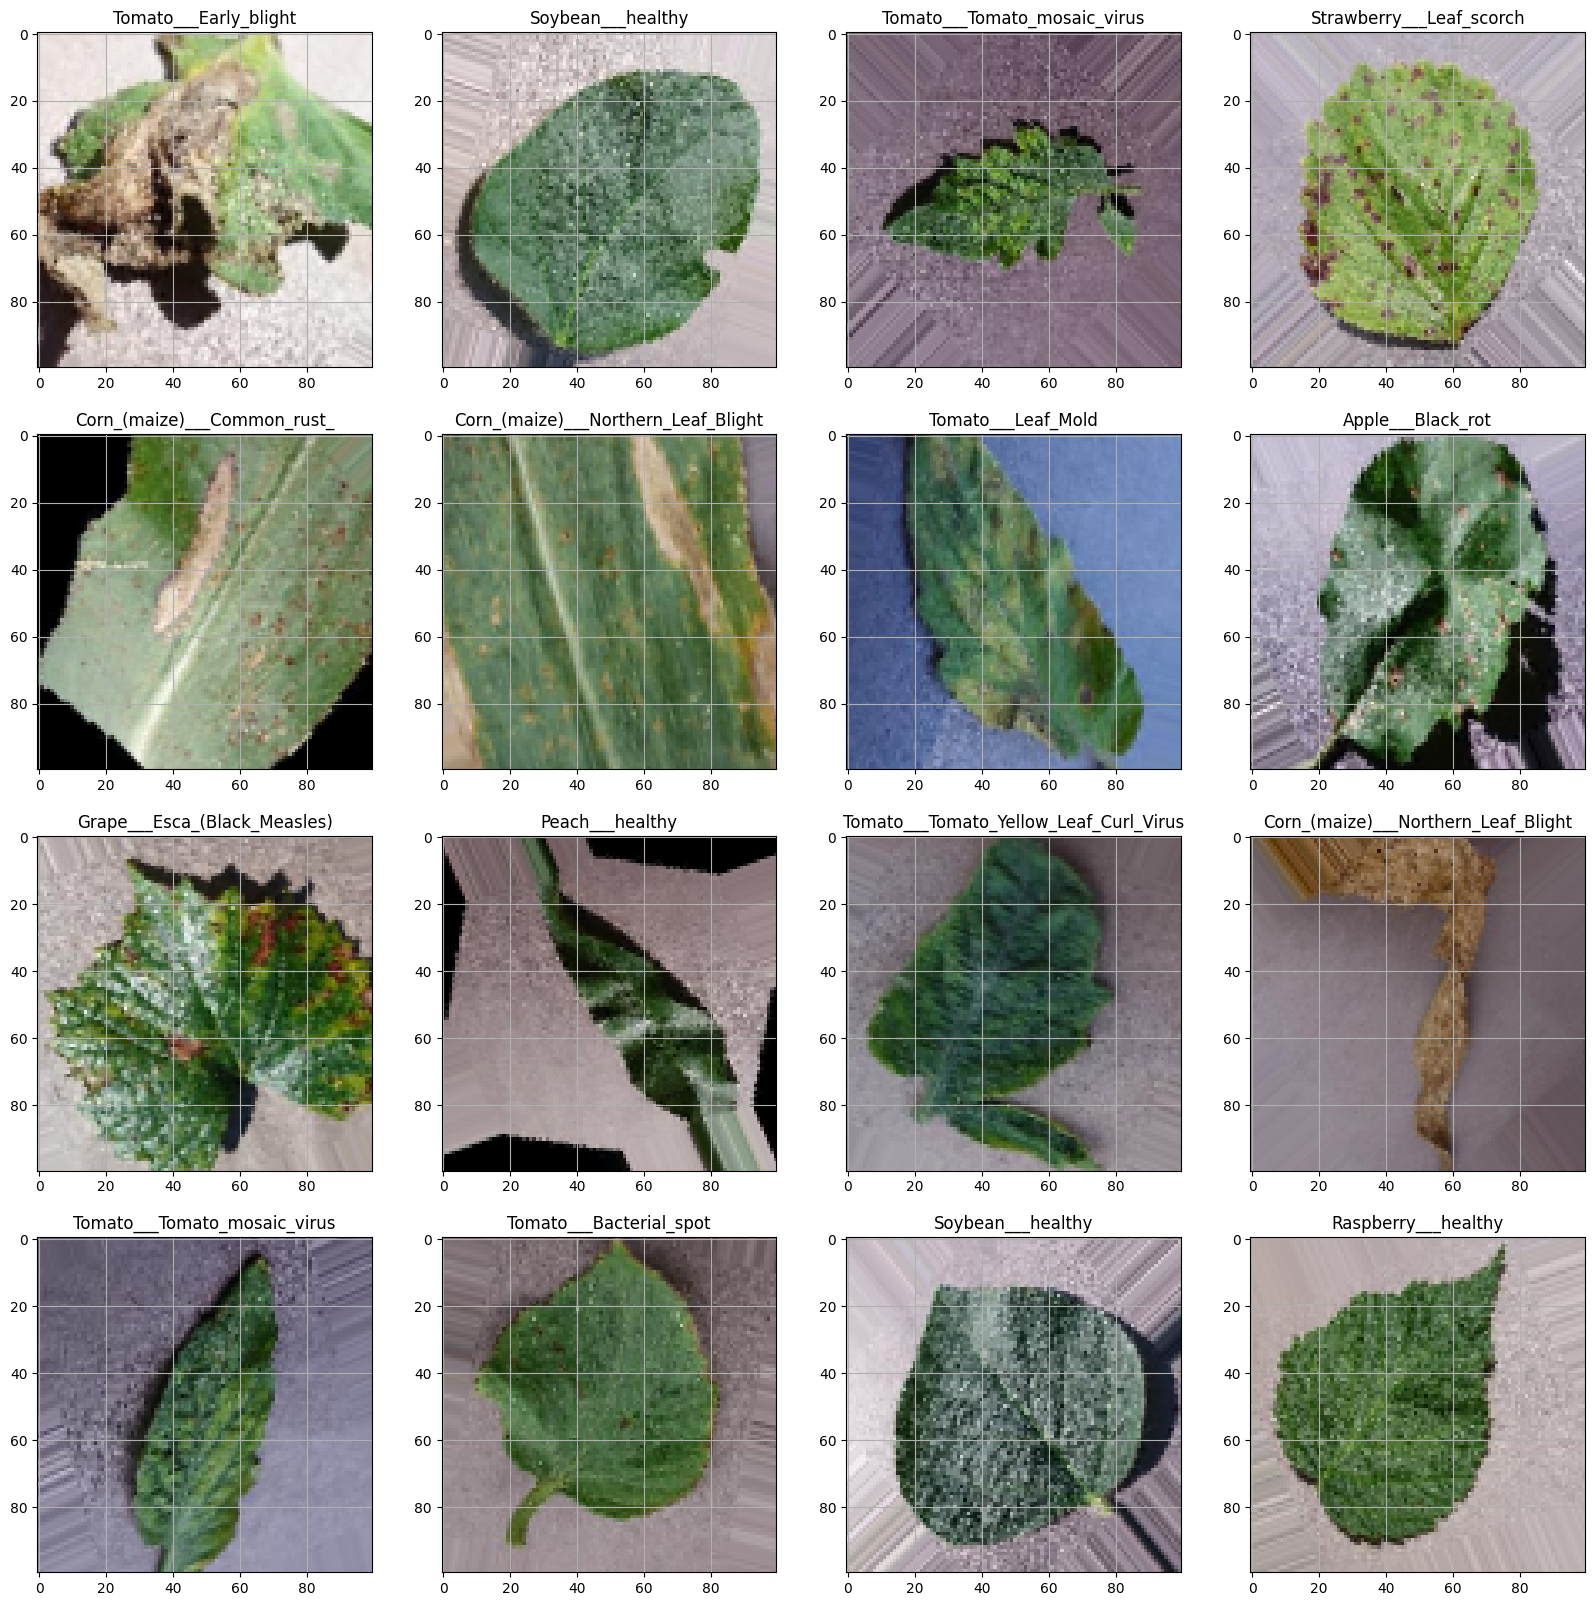

In [6]:
plt.figure(figsize=(20,20))
for X_batch, y_batch in train_generator:
    # create a grid of 3x3 images
    for i in range(0,16):
        plt.subplot(4,4,i+1)
        plt.imshow(X_batch[i])
        plt.title(labels[np.where(y_batch[i]==1)[0][0]])   # when y is categorical
        # plt.title(classes[int(y_batch[i])])   # when y is binary or sparse
        plt.grid(None)
    # show the plot
    plt.show()
    break

In [7]:
validation_generator = tf.keras.preprocessing.image.ImageDataGenerator(
    rotation_range=50,  # Apply same augmentations
    zoom_range=0.2,
    rescale=1/255.0,
    validation_split=0.1,  # Same validation split
).flow_from_directory(train_path,
                      batch_size=64,
                      target_size=(img_size, img_size),
                      subset="validation",  # Access validation data (10%)
                      color_mode='rgb',
                      class_mode='categorical',
                      shuffle=True)

Found 7013 images belonging to 38 classes.


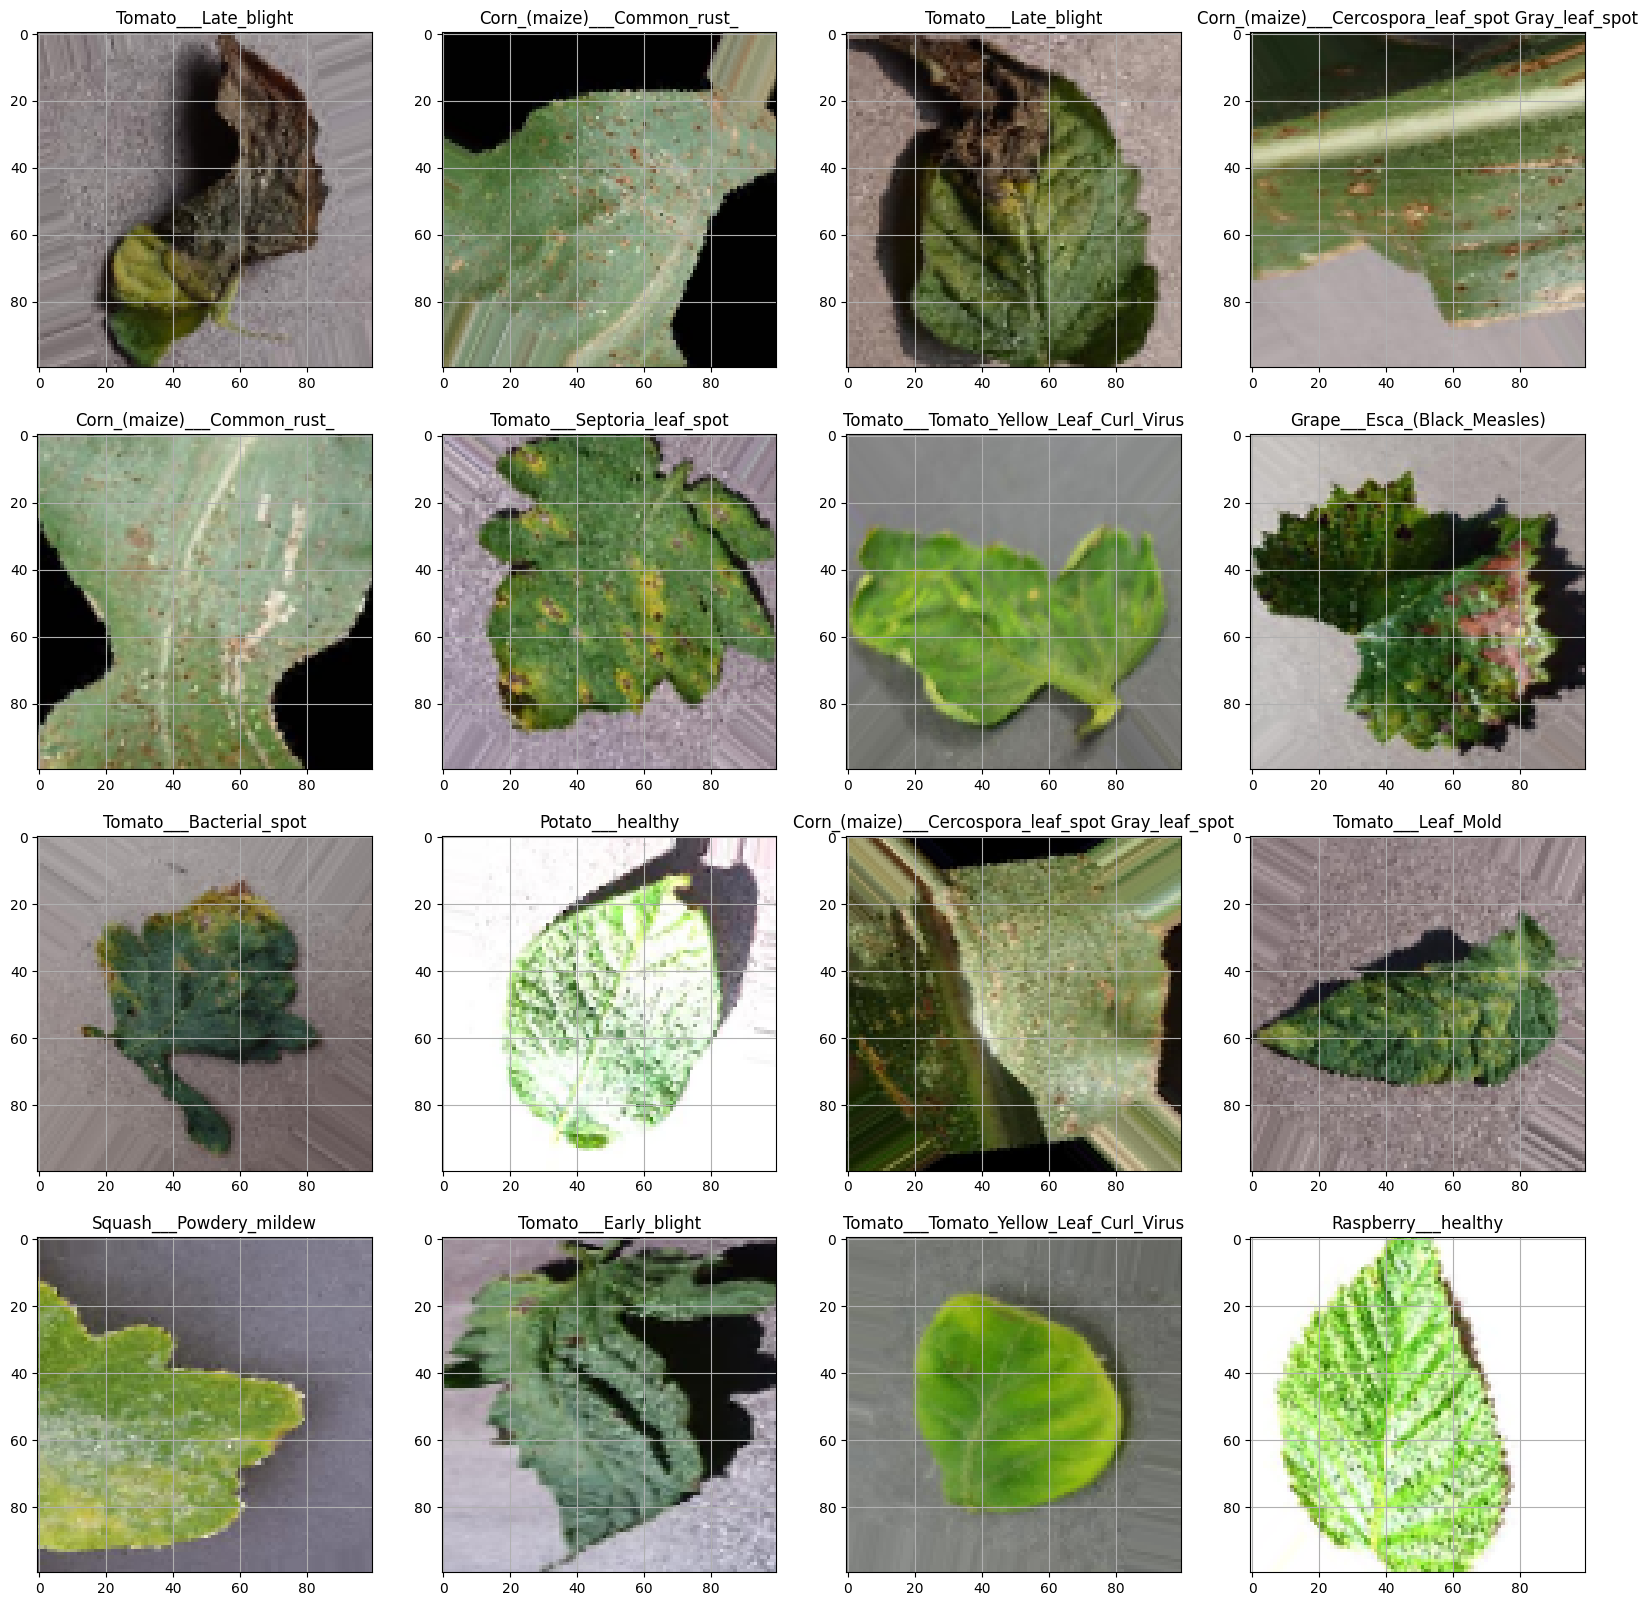

In [8]:
plt.figure(figsize=(20,20))
for X_batch, y_batch in validation_generator:
    # create a grid of 3x3 images
    for i in range(0,16):
        plt.subplot(4,4,i+1)
        plt.imshow(X_batch[i])
        plt.title(labels[np.where(y_batch[i]==1)[0][0]])   # when y is categorical
        # plt.title(classes[int(y_batch[i])])   # when y is binary or sparse
        plt.grid(None)
    # show the plot
    plt.show()
    break

In [9]:
test_generator=tf.keras.preprocessing.image.ImageDataGenerator(
    rotation_range=50,
    zoom_range=0.2,
    rescale=1/255.0,
    preprocessing_function=None,
).flow_from_directory(test_path,
                      batch_size=64,
                      target_size=(img_size, img_size),
                      color_mode='rgb',
                      class_mode='categorical',
                      shuffle=False)

Found 17572 images belonging to 38 classes.


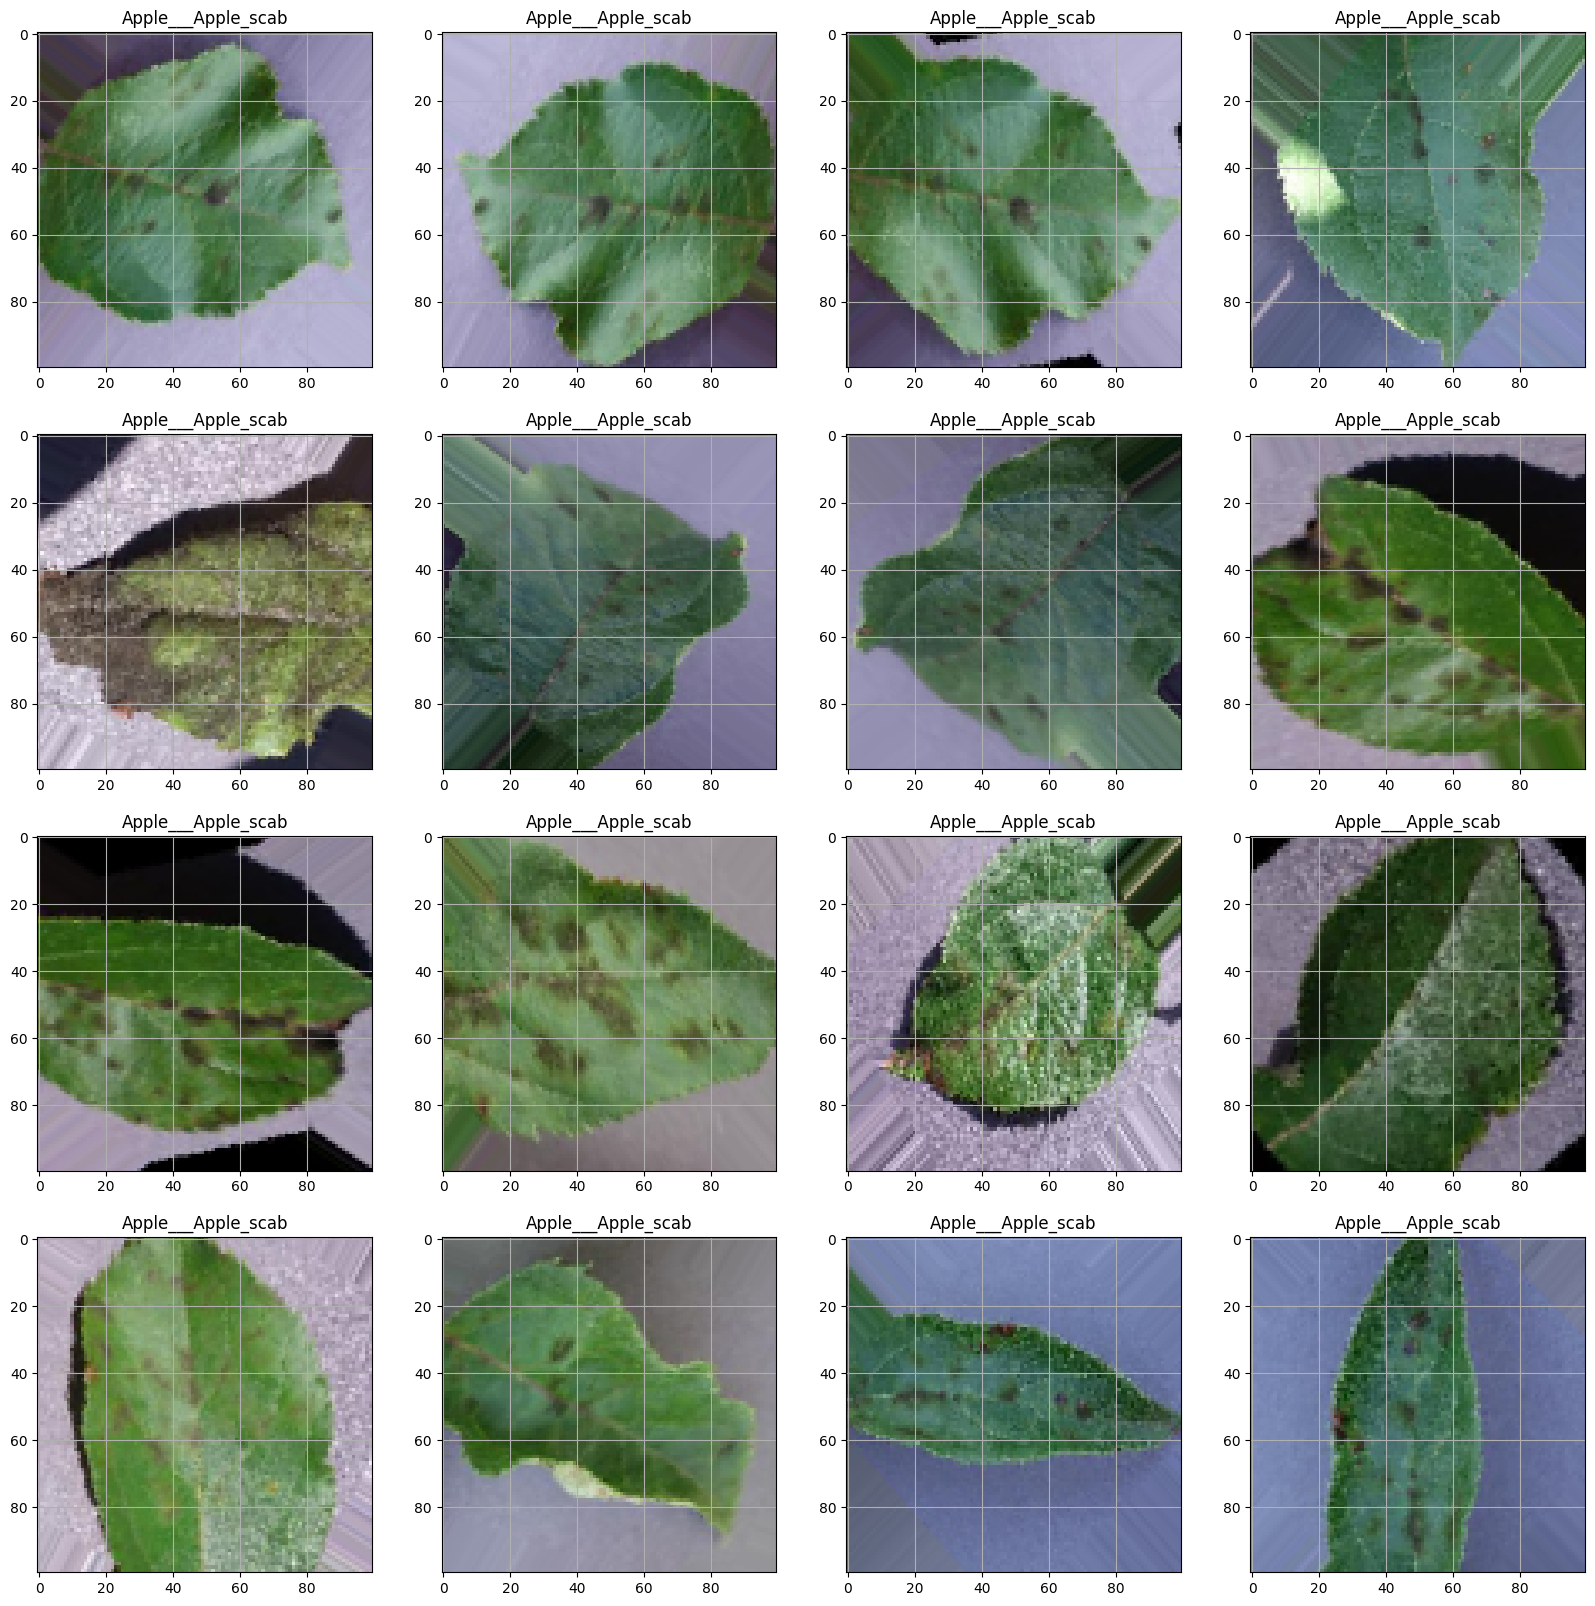

In [10]:
plt.figure(figsize=(20,20))
for X_batch, y_batch in test_generator:
    # create a grid of 3x3 images
    for i in range(0,16):
        plt.subplot(4,4,i+1)
        plt.imshow(X_batch[i])
        plt.title(labels[np.where(y_batch[i]==1)[0][0]])   # when y is categorical
        # plt.title(classes[int(y_batch[i])])   # when y is binary or sparse
        plt.grid(None)
    # show the plot
    plt.show()
    break

In [11]:
size = (img_size, img_size, 3)
num_classes = len(labels)


CNN_model = Sequential([

    Conv2D(32, (3, 3), activation='relu', input_shape=size),
    MaxPooling2D(pool_size=(2, 2)),
    Conv2D(64, (3, 3), activation='relu'),
    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D(pool_size=(2, 2)),
    Dropout(0.3),
    Conv2D(128, (3, 3), activation='relu'),
    Conv2D(128, (3, 3), activation='relu'),
    MaxPooling2D(pool_size=(2, 2)),
    Dropout(0.4),
    Flatten(),
    Dense(128, activation='relu'),
    Dropout(0.4),
    Dense(num_classes, activation='softmax')
    ])




/opt/conda/lib/python3.10/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [12]:
# Compile the model
CNN_model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy', 'precision', 'recall'])

In [13]:
CNN_model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 98, 98, 32)     │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 49, 49, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 47, 47, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 45, 45, 64)     │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 22, 22, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 22, 22, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 20, 20, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 18, 18, 128)    │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 9, 9, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 9, 9, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 10368)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │     1,327,232 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 38)             │         4,902 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,609,894 (6.14 MB)

 Trainable params: 1,609,894 (6.14 MB)

 Non-trainable params: 0 (0.00 B)

In [14]:
# Define early stopping
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)


In [15]:
history_CNN = CNN_model.fit(train_generator,
                    epochs = 30,
                    batch_size=64,
                    validation_data = validation_generator,
                    callbacks = early_stopping
                    )

Epoch 1/30


/opt/conda/lib/python3.10/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()
I0000 00:00:1729744790.938544      89 service.cc:145] XLA service 0x7a42180031f0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1729744790.938603      89 service.cc:153]   StreamExecutor device (0): Tesla P100-PCIE-16GB, Compute Capability 6.0


  1/989 ━━━━━━━━━━━━━━━━━━━━ 4:03:56 15s/step - accuracy: 0.0469 - loss: 3.6361 - precision: 0.0000e+00 - recall: 0.0000e+00

I0000 00:00:1729744798.639003      89 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


989/989 ━━━━━━━━━━━━━━━━━━━━ 694s 688ms/step - accuracy: 0.1992 - loss: 2.9046 - precision: 0.6224 - recall: 0.0670 - val_accuracy: 0.6464 - val_loss: 1.2229 - val_precision: 0.8498 - val_recall: 0.4194
Epoch 2/30
989/989 ━━━━━━━━━━━━━━━━━━━━ 257s 258ms/step - accuracy: 0.5641 - loss: 1.4079 - precision: 0.7531 - recall: 0.3934 - val_accuracy: 0.7271 - val_loss: 0.8833 - val_precision: 0.8335 - val_recall: 0.6196
Epoch 3/30
989/989 ━━━━━━━━━━━━━━━━━━━━ 258s 259ms/step - accuracy: 0.6675 - loss: 1.0834 - precision: 0.8022 - recall: 0.5384 - val_accuracy: 0.8179 - val_loss: 0.5873 - val_precision: 0.8894 - val_recall: 0.7455
Epoch 4/30
989/989 ━━━━━━━━━━━━━━━━━━━━ 265s 267ms/step - accuracy: 0.7369 - loss: 0.8443 - precision: 0.8346 - recall: 0.6465 - val_accuracy: 0.8305 - val_loss: 0.5468 - val_precision: 0.8855 - val_recall: 0.7827
Epoch 5/30
989/989 ━━━━━━━━━━━━━━━━━━━━ 257s 258ms/step - accuracy: 0.7785 - loss: 0.7038 - precision: 0.8542 - recall: 0.7092 - val_accuracy: 0.8925 - val

In [16]:
CNN_model.save('CNN_model.h5')


In [17]:
# Evaluate the model
train_loss, train_accuracy, train_precision, train_recall= CNN_model.evaluate(train_generator)
test_loss, test_accuracy, test_precision, test_recall= CNN_model.evaluate(test_generator)

989/989 ━━━━━━━━━━━━━━━━━━━━ 231s 234ms/step - accuracy: 0.9658 - loss: 0.1020 - precision: 0.9717 - recall: 0.9611
275/275 ━━━━━━━━━━━━━━━━━━━━ 184s 670ms/step - accuracy: 0.9678 - loss: 0.1009 - precision: 0.9730 - recall: 0.9621


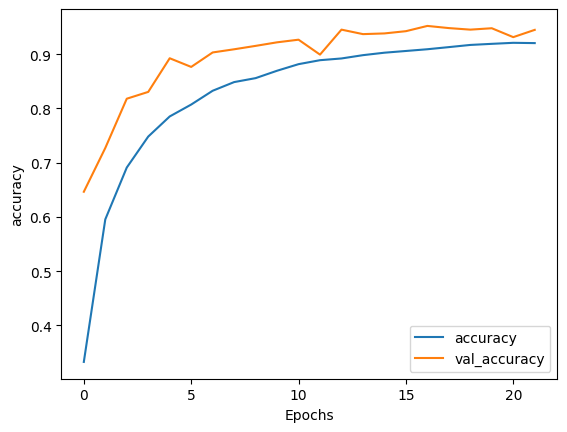

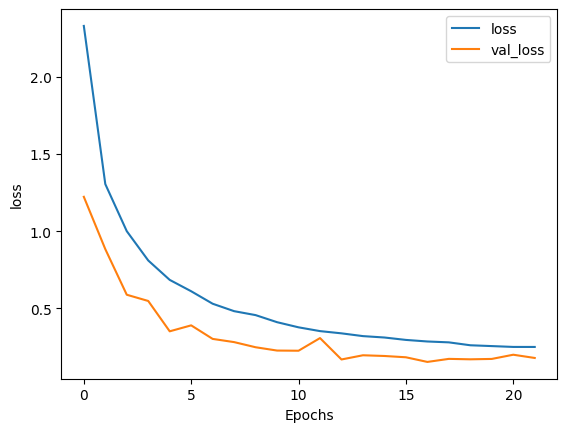

In [18]:
def plot_graphs(history, string):
  plt.plot(history.history[string])
  plt.plot(history.history['val_'+ string])
  plt.xlabel('Epochs')
  plt.ylabel(string)
  plt.legend([string,'val_'+ string ])
  plt.show()

plot_graphs(history_CNN, 'accuracy')
plot_graphs(history_CNN, 'loss')

In [19]:
from sklearn.metrics import precision_score, recall_score, f1_score

y_train_pred = CNN_model.predict(train_generator)
y_test_pred = CNN_model.predict(test_generator)

y_train_pred_class = np.argmax(y_train_pred, axis=1)
y_test_pred_class = np.argmax(y_test_pred, axis=1)

# Get the true class labels
y_train_true = train_generator.classes
y_test_true = test_generator.classes


f1_train = f1_score(y_train_true, y_train_pred_class, average='weighted')
f1_test = f1_score(y_test_true, y_test_pred_class, average='weighted')

989/989 ━━━━━━━━━━━━━━━━━━━━ 240s 243ms/step
275/275 ━━━━━━━━━━━━━━━━━━━━ 64s 233ms/step


In [20]:
data = {
    'model': ['CNN'],
    'Accuracy train': [train_accuracy],
    'Accuracy test': [test_accuracy],
    'Precision train': [train_precision],
    'Precision test': [test_precision],
    'Recall train': [train_recall],
    'Recall test': [test_recall],
    'F1-score train': [f1_train],
    'F1-score test': [f1_test]
}


metrics_df = pd.DataFrame(data)
metrics_df

,model,Accuracy train,Accuracy test,Precision train,Precision test,Recall train,Recall test,F1-score train,F1-score test
0,CNN,0.966784,0.958058,0.972387,0.964242,0.962138,0.951457,0.026546,0.957131
